In [2]:
#pip install regionmask

In [3]:
import matplotlib.pyplot as plt
import xarray as xr
import geopandas as gp
import numpy as np
from shapely.geometry import MultiPolygon, Polygon
import cartopy.crs as ccrs
import cartopy.feature
import matplotlib.colors as mcolors
import regionmask
from xmip.regionmask import merged_mask
import pandas as pd
import gcsfs
import cmocean

# %matplotlib widget
fs = gcsfs.GCSFileSystem()
%run _Val_Mapping.ipynb

# Make regional masks

In [4]:
#from this webpage: https://www.marineregions.org

bering = gp.read_file('/home/jovyan/mCDR/shapefiles/bering.zip')
gulf = gp.read_file('/home/jovyan/mCDR/shapefiles/gulf.zip')
caribbean = gp.read_file('/home/jovyan/mCDR/shapefiles/caribbean.zip')

lon = np.arange(-180, 180,.1)
lat = np.arange(-90, 90,.1)

mask_bering = regionmask.mask_geopandas(bering, lon, lat)
mask_gulf = regionmask.mask_geopandas(gulf, lon, lat)
mask_caribbean = regionmask.mask_geopandas(caribbean, lon, lat)

## Bring in HR-CESM-testbed 'truth' and reconstructions

In [5]:
truth = xr.open_dataset('gs://leap-persistent/abbysh/ncar_files/processed/pco2_components_202002-202201.zarr', engine='zarr').pCO2SURF 
unseen_global_2000_2022 = xr.open_dataset('gs://leap-persistent/abbysh/ncar_files/post02_xgb_output/0022_global/reconstructions/recon_pCO2_nmse_mon_01x01_202002-202201.zarr', engine='zarr').pco2_recon_unseen
unseen_targeted_2000_2022_north = xr.open_dataset('gs://leap-persistent/abbysh/ncar_files/post02_xgb_output/0022_north/reconstructions/recon_pCO2_nmse_mon_01x01_202002-202201.zarr', engine='zarr').pco2_recon_unseen
unseen_targeted_2000_2022_bering = xr.open_dataset('gs://leap-persistent/abbysh/ncar_files/post02_xgb_output/0022_bering/reconstructions/recon_pCO2_nmse_mon_01x01_202002-202201.zarr', engine='zarr').pco2_recon_unseen
unseen_targeted_2000_2022_caribbean = xr.open_dataset('gs://leap-persistent/abbysh/ncar_files/post02_xgb_output/0022_caribbean/reconstructions/recon_pCO2_nmse_mon_01x01_202002-202201.zarr', engine='zarr').pco2_recon_unseen

unseen_global_2020_2022 = xr.open_dataset('gs://leap-persistent/abbysh/ncar_files/post02_xgb_output/2022_global/reconstructions/recon_pCO2_nmse_mon_01x01_202002-202201.zarr', engine='zarr').pco2_recon_unseen
unseen_global_2020_2022_float = xr.open_dataset('gs://leap-persistent/abbysh/ncar_files/post02_xgb_output/2022_global_float/reconstructions/recon_pCO2_nmse_mon_01x01_202002-202201.zarr', engine='zarr').pco2_recon_unseen
unseen_targeted_2020_2022_caribbean = xr.open_dataset('gs://leap-persistent/abbysh/ncar_files/post02_xgb_output/2022_caribbean/reconstructions/recon_pCO2_nmse_mon_01x01_202002-202201.zarr', engine='zarr').pco2_recon_unseen
unseen_targeted_2020_2022_bering = xr.open_dataset('gs://leap-persistent/abbysh/ncar_files/post02_xgb_output/2022_bering/reconstructions/recon_pCO2_nmse_mon_01x01_202002-202201.zarr', engine='zarr').pco2_recon_unseen

# Assign_dimension coordinates
truth = truth.assign_coords(status='truth')
unseen_global_2000_2022 = unseen_global_2000_2022.assign_coords(status='reconstruction')
unseen_targeted_2000_2022_north = unseen_targeted_2000_2022_north.assign_coords(status='reconstruction')
unseen_targeted_2000_2022_bering = unseen_targeted_2000_2022_bering.assign_coords(status='reconstruction')
unseen_targeted_2000_2022_caribbean = unseen_targeted_2000_2022_caribbean.assign_coords(status='reconstruction')

unseen_global_2020_2022 = unseen_global_2020_2022.assign_coords(status='reconstruction')
unseen_global_2020_2022_float = unseen_global_2020_2022_float.assign_coords(status='reconstruction')
unseen_targeted_2020_2022_caribbean = unseen_targeted_2020_2022_caribbean.assign_coords(status='reconstruction')
unseen_targeted_2020_2022_bering = unseen_targeted_2020_2022_bering.assign_coords(status='reconstruction')

# Make sure they have the same time coordinates
#truth = truth.assign_coords(unseen_global_2000_2022['time'].data)
CESM_ds_global_2000_2022 = xr.concat([truth, unseen_global_2000_2022], dim='status')
CESM_ds_targeted_2000_2022_north = xr.concat([truth, unseen_targeted_2000_2022_north], dim='status')
CESM_ds_targeted_2000_2022_bering = xr.concat([truth, unseen_targeted_2000_2022_bering], dim='status')
CESM_ds_targeted_2000_2022_caribbean = xr.concat([truth, unseen_targeted_2000_2022_caribbean], dim='status')

CESM_ds_global_2020_2022 = xr.concat([truth, unseen_global_2020_2022], dim='status')
CESM_ds_global_2020_2022_float = xr.concat([truth, unseen_global_2020_2022_float], dim='status')
CESM_ds_targeted_2020_2022_caribbean = xr.concat([truth, unseen_targeted_2020_2022_caribbean], dim='status')
CESM_ds_targeted_2020_2022_bering = xr.concat([truth, unseen_targeted_2020_2022_bering], dim='status')

## Calculate reconstruction bias and RMSE for maps

In [5]:
# Bias
bias_global_2000_2022 = CESM_ds_global_2000_2022.diff('status').sel(time=slice("2020-02-01",'2022-01-01')).mean(['time','status'])
bias_targeted_2000_2022_north = CESM_ds_targeted_2000_2022_north.diff('status').sel(time=slice("2020-02-01",'2022-01-01')).mean(['time','status'])
bias_targeted_2000_2022_bering = CESM_ds_targeted_2000_2022_bering.diff('status').sel(time=slice("2020-02-01",'2022-01-01')).mean(['time','status'])
bias_targeted_2000_2022_caribbean = CESM_ds_targeted_2000_2022_caribbean.diff('status').sel(time=slice("2020-02-01",'2022-01-01')).mean(['time','status'])

bias_global_2020_2022 = CESM_ds_global_2020_2022.diff('status').sel(time=slice("2020-02-01",'2022-01-01')).mean(['time','status'])
bias_global_2020_2022_float = CESM_ds_global_2020_2022_float.diff('status').sel(time=slice("2020-02-01",'2022-01-01')).mean(['time','status'])
bias_targeted_2020_2022_caribbean = CESM_ds_targeted_2020_2022_caribbean.diff('status').sel(time=slice("2020-02-01",'2022-01-01')).mean(['time','status'])
bias_targeted_2020_2022_bering = CESM_ds_targeted_2020_2022_bering.diff('status').sel(time=slice("2020-02-01",'2022-01-01')).mean(['time','status'])

# RMSE
rmse_global_2000_2022 = np.sqrt(((CESM_ds_global_2000_2022.diff('status'))**2).sel(time=slice("2020-02-01",'2022-01-01')).mean(['time','status']))
rmse_targeted_2000_2022_north = np.sqrt(((CESM_ds_targeted_2000_2022_north.diff('status'))**2).sel(time=slice("2020-02-01",'2022-01-01')).mean(['time','status']))
rmse_targeted_2000_2022_bering = np.sqrt(((CESM_ds_targeted_2000_2022_bering.diff('status'))**2).sel(time=slice("2020-02-01",'2022-01-01')).mean(['time','status']))
rmse_targeted_2000_2022_caribbean = np.sqrt(((CESM_ds_targeted_2000_2022_caribbean.diff('status'))**2).sel(time=slice("2020-02-01",'2022-01-01')).mean(['time','status']))

rmse_global_2020_2022 = np.sqrt(((CESM_ds_global_2020_2022.diff('status'))**2).sel(time=slice("2020-02-01",'2022-01-01')).mean(['time','status']))
rmse_global_2020_2022_float = np.sqrt(((CESM_ds_global_2020_2022_float.diff('status'))**2).sel(time=slice("2020-02-01",'2022-01-01')).mean(['time','status']))
rmse_targeted_2020_2022_caribbean = np.sqrt(((CESM_ds_targeted_2020_2022_caribbean.diff('status'))**2).sel(time=slice("2020-02-01",'2022-01-01')).mean(['time','status']))
rmse_targeted_2020_2022_bering = np.sqrt(((CESM_ds_targeted_2020_2022_bering.diff('status'))**2).sel(time=slice("2020-02-01",'2022-01-01')).mean(['time','status']))

## Figure 3b

<>:29: SyntaxWarning: invalid escape sequence '\m'
<>:29: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_53/1102906190.py:29: SyntaxWarning: invalid escape sequence '\m'
  rmse_global_2020_2022.plot(ax=ax, transform=ccrs.PlateCarree(),vmin=0, vmax=20, cmap=cmocean.cm.deep, cbar_kwargs={'shrink': 0.6,'label': 'Mean 2020-2021 RMSE ($\mu atm$)'}) #


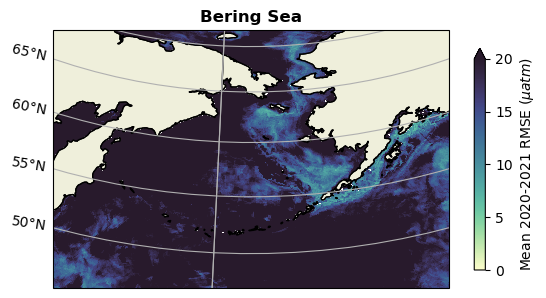

In [22]:
central_lon = -96
central_lat = 45

extent = [-200, -150, 45, 70] # Bering Sea

central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

ax = plt.axes(projection=ccrs.AlbersEqualArea(central_lon, central_lat))
ax.set_extent(extent)

ax.coastlines(resolution='50m')
ax.add_feature(cartopy.feature.LAND, edgecolor='black')

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.left_labels = True
gl.bottom_labels = False
                                                              
rmse_global_2020_2022.plot(ax=ax, transform=ccrs.PlateCarree(),vmin=0, vmax=20, cmap=cmocean.cm.deep, cbar_kwargs={'shrink': 0.6,'label': 'Mean 2020-2021 RMSE ($\mu atm$)'}) 

plt.title('Bering Sea', fontsize=12, fontweight='bold');

#plt.savefig("/home/jovyan/rmse_bering_2020_2022.jpg",dpi=300, bbox_inches="tight");

## Figure 3c

<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_439/2557098227.py:22: SyntaxWarning: invalid escape sequence '\m'
  rmse_global_2020_2022.plot(ax=ax, transform=ccrs.PlateCarree(),vmin=0, vmax=20, cmap=cmocean.cm.deep, cbar_kwargs={'shrink': 0.6,'label': 'Mean 2020-2021 RMSE ($\mu atm$)'}) #


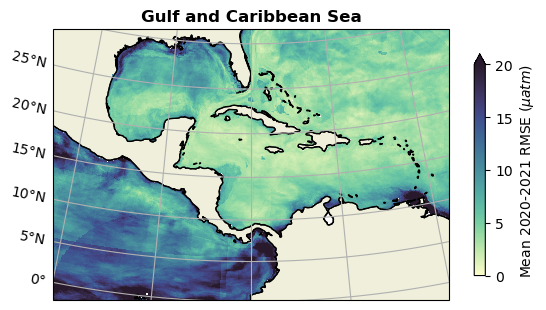

In [6]:
central_lon = -96
central_lat = 45
extent = [-100, -60, 0, 30] #Gulf of Mexico and Caribbean Sea

central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

ax = plt.axes(projection=ccrs.AlbersEqualArea(central_lon, central_lat))
ax.set_extent(extent)

ax.coastlines(resolution='50m')
ax.add_feature(cartopy.feature.LAND, edgecolor='black')

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.left_labels = True
gl.bottom_labels = False
                                                                
rmse_global_2020_2022.plot(ax=ax, transform=ccrs.PlateCarree(),vmin=0, vmax=20, cmap=cmocean.cm.deep, cbar_kwargs={'shrink': 0.6,'label': 'Mean 2020-2021 RMSE ($\mu atm$)'}) 

plt.title('Gulf and Caribbean Sea', fontsize=12, fontweight='bold');
#plt.savefig("/home/jovyan/rmse_bering_2020_2022.jpg",dpi=300, bbox_inches="tight");

## Figure 4b

<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_439/2120270470.py:21: SyntaxWarning: invalid escape sequence '\m'
  bias_global_2020_2022.plot(ax=ax, transform=ccrs.PlateCarree(),vmin=-10, vmax=10, cmap=cmocean.cm.curl, cbar_kwargs={'shrink': 0.6,'label': 'Mean 2020-2021 bias ($\mu atm$)'}) #


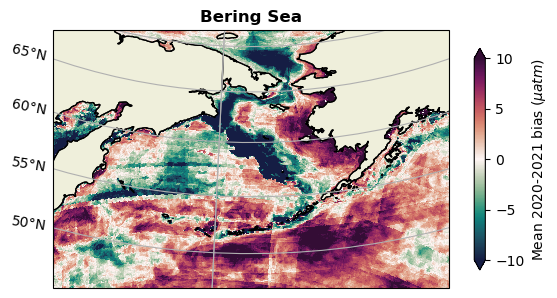

In [7]:
central_lon = -96
central_lat = 45
extent = [-200, -150, 45, 70] # Bering

central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

ax = plt.axes(projection=ccrs.AlbersEqualArea(central_lon, central_lat))
ax.set_extent(extent)

ax.coastlines(resolution='50m')
ax.add_feature(cartopy.feature.LAND, edgecolor='black')

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.left_labels = True
gl.bottom_labels = False

bias_global_2020_2022.plot(ax=ax, transform=ccrs.PlateCarree(),vmin=-10, vmax=10, cmap=cmocean.cm.curl, cbar_kwargs={'shrink': 0.6,'label': 'Mean 2020-2021 bias ($\mu atm$)'}) #

plt.title('Bering Sea', fontsize=12, fontweight='bold');
#plt.savefig("/home/jovyan/bias_gulf_2020.jpg",dpi=300, bbox_inches="tight")

## Figure 4c

<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_439/979287504.py:21: SyntaxWarning: invalid escape sequence '\m'
  bias_global_2020_2022.plot(ax=ax, transform=ccrs.PlateCarree(),vmin=-10, vmax=10, cmap=cmocean.cm.curl, cbar_kwargs={'shrink': 0.6,'label': 'Mean 2020-2021 bias ($\mu atm$)'}) #


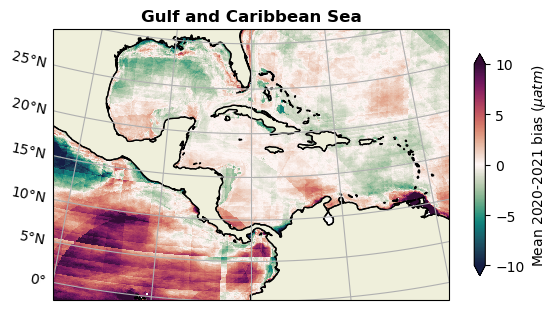

In [8]:
central_lon = -96
central_lat = 45
extent = [-100, -60, 0, 30] #Gulf of Mexico and Caribbean Sea

central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

ax = plt.axes(projection=ccrs.AlbersEqualArea(central_lon, central_lat))
ax.set_extent(extent)

ax.coastlines(resolution='50m')
ax.add_feature(cartopy.feature.LAND, edgecolor='black')

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.left_labels = True
gl.bottom_labels = False

### Testbed (bias/RMSE/truth) ###
bias_global_2020_2022.plot(ax=ax, transform=ccrs.PlateCarree(),vmin=-10, vmax=10, cmap=cmocean.cm.curl, cbar_kwargs={'shrink': 0.6,'label': 'Mean 2020-2021 bias ($\mu atm$)'}) #

plt.title('Gulf and Caribbean Sea', fontsize=12, fontweight='bold');
#plt.savefig("/home/jovyan/bias_gulf_2020.jpg",dpi=300, bbox_inches="tight")

## Figure 6

### Filter RMSE values to 2 uatm or less

In [9]:
filtered_2020 = rmse_global_2020_2022.where((rmse_global_2020_2022 >= 0) & (rmse_global_2020_2022 <= 2))
filtered_2020_float = rmse_global_2020_2022_float.where((rmse_global_2020_2022_float >= 0) & (rmse_global_2020_2022_float <= 2))
filtered_2000 = rmse_global_2000_2022.where((rmse_global_2000_2022 >= 0) & (rmse_global_2000_2022 <= 2))

<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_439/80902127.py:36: SyntaxWarning: invalid escape sequence '\m'
  cbar.set_label('Mean 2020-2021 RMSE ($\mu atm$)', fontsize=12);


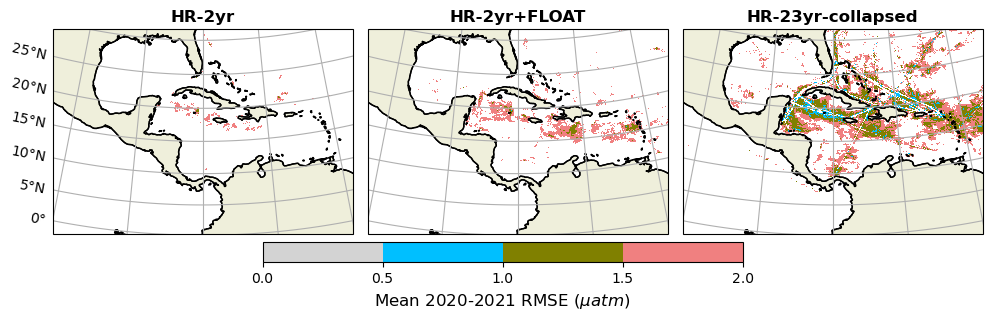

In [10]:
extent = [-100, -60, 0, 30]  # Gulf of Mexico and Caribbean Sea

central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

datasets = [filtered_2020, filtered_2020_float, filtered_2000]
titles = ["HR-2yr", "HR-2yr+FLOAT", "HR-23yr-collapsed"]

colors = ['lightgray', 'deepskyblue', 'olive', 'lightcoral']  
cmap = mcolors.ListedColormap(colors)
bounds = [0, 0.5, 1, 1.5, 2]  
norm = mcolors.BoundaryNorm(bounds, cmap.N)

fig, axes = plt.subplots(1, 3, figsize=(12, 4), 
                         subplot_kw={'projection': ccrs.AlbersEqualArea(central_lon, central_lat)})

plt.subplots_adjust(wspace=0.05, hspace=0) 

for i, (ax, data, title) in enumerate(zip(axes, datasets, titles)):
    ax.set_extent(extent)
    ax.coastlines(resolution='50m')
    ax.add_feature(cartopy.feature.LAND, edgecolor='black')

    gl = ax.gridlines(draw_labels=True)
    gl.left_labels = (i == 0)  
    gl.right_labels = False  
    gl.top_labels = False  
    gl.bottom_labels = False

    img = data.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=0, vmax=2, cmap=cmap, norm=norm, add_colorbar=False)
    
    ax.set_title(title, fontsize=12, fontweight='bold')

cbar_ax = fig.add_axes([0.3, 0.17, 0.4, 0.05])  # x, vertical position, width, height
cbar = fig.colorbar(img, cax=cbar_ax, orientation='horizontal', ticks=bounds)
cbar.set_label('Mean 2020-2021 RMSE ($\mu atm$)', fontsize=12);

#plt.savefig("/home/jovyan/rmse_filtered.jpg",dpi=300, bbox_inches="tight");

## Figure 7

<>:31: SyntaxWarning: invalid escape sequence '\m'
<>:31: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_439/2040125321.py:31: SyntaxWarning: invalid escape sequence '\m'
  cbar.set_label("Mean 2020-2021 RMSE ($\mu atm$)", fontsize=12);


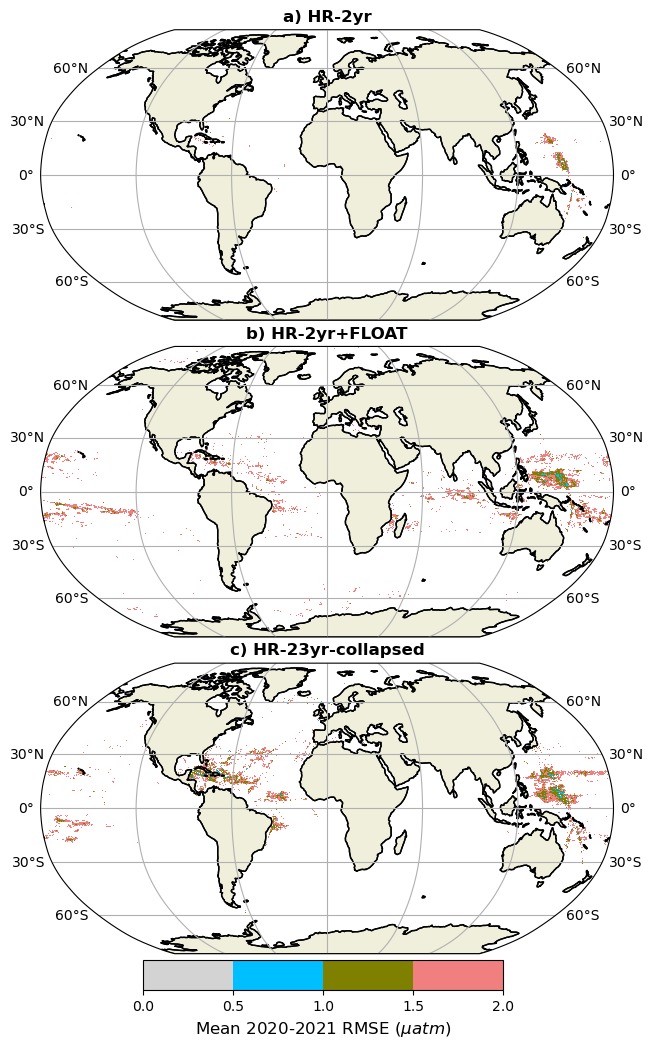

In [11]:
projection = ccrs.Robinson()

fig, axes = plt.subplots(3, 1, figsize=(15, 12), subplot_kw={'projection': projection})

plt.subplots_adjust(hspace=0.09)  

colors = ['lightgray', 'deepskyblue', 'olive', 'lightcoral']
cmap = mcolors.ListedColormap(colors)
bounds = [0, 0.5, 1, 1.5, 2]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

datasets = [filtered_2020, filtered_2020_float, filtered_2000]
titles = ["a) HR-2yr", "b) HR-2yr+FLOAT", "c) HR-23yr-collapsed"]

for i, (ax, data, title) in enumerate(zip(axes, datasets, titles)):
    ax.set_global()  
    ax.coastlines(resolution='110m')  
    ax.add_feature(cfeature.LAND, edgecolor='black')

    gl = ax.gridlines(draw_labels=True)
    gl.left_labels = True  
    gl.right_labels = True
    gl.top_labels = False
    gl.bottom_labels = False

    img = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
    ax.set_title(title, fontsize=12, fontweight="bold")

cbar_ax = fig.add_axes([0.39, 0.08, 0.24, 0.025])  # x, vertical position, width, height
cbar = fig.colorbar(img, cax=cbar_ax, orientation="horizontal", ticks=bounds)
cbar.set_label("Mean 2020-2021 RMSE ($\mu atm$)", fontsize=12);

#plt.savefig("/home/jovyan/rmse.jpg",dpi=300, bbox_inches="tight");

## Table 2 and Figure S1

In [6]:
# Rename variables so that region masks match sampling masks
mask_bering  = mask_bering.to_dataset().rename({"lon":"longitude", "lat": "latitude"})
mask_gulf  = mask_gulf.to_dataset().rename({"lon":"longitude", "lat": "latitude"})
mask_caribbean = mask_caribbean.to_dataset().rename({"lon":"longitude", "lat": "latitude"})

In [13]:
# Apply region masks to bias/RMSE calculations for the various experiments

### Bering Sea ###
bias_masked_bering_global_2000_2022 = bias_global_2000_2022.where(mask_bering.mask.values==0.)
bias_masked_bering_targeted_2000_2022_north = bias_targeted_2000_2022_north.where(mask_bering.mask.values==0.)
bias_masked_bering_targeted_2000_2022_bering = bias_targeted_2000_2022_bering.where(mask_bering.mask.values==0.)
bias_masked_bering_global_2020_2022 = bias_global_2020_2022.where(mask_bering.mask.values==0.)
bias_masked_bering_global_2020_2022_float = bias_global_2020_2022_float.where(mask_bering.mask.values==0.)
bias_masked_bering_targeted_2020_2022_bering = bias_targeted_2020_2022_bering.where(mask_bering.mask.values==0.)

rmse_masked_bering_global_2000_2022 = rmse_global_2000_2022.where(mask_bering.mask.values==0.)
rmse_masked_bering_targeted_2000_2022_north = rmse_targeted_2000_2022_north.where(mask_bering.mask.values==0.)
rmse_masked_bering_targeted_2000_2022_bering = rmse_targeted_2000_2022_bering.where(mask_bering.mask.values==0.)
rmse_masked_bering_global_2020_2022 = rmse_global_2020_2022.where(mask_bering.mask.values==0.)
rmse_masked_bering_global_2020_2022_float = rmse_global_2020_2022_float.where(mask_bering.mask.values==0.)
rmse_masked_bering_targeted_2020_2022_bering = rmse_targeted_2020_2022_bering.where(mask_bering.mask.values==0.)

### Gulf of Mexico ###
bias_masked_gulf_global_2000_2022 = bias_global_2000_2022.where(mask_gulf.mask.values==0.)
bias_masked_gulf_global_2020_2022 = bias_global_2020_2022.where(mask_gulf.mask.values==0.)
bias_masked_gulf_global_2020_2022_float = bias_global_2020_2022_float.where(mask_gulf.mask.values==0.)

rmse_masked_gulf_global_2000_2022 = rmse_global_2000_2022.where(mask_gulf.mask.values==0.)
rmse_masked_gulf_global_2020_2022 = rmse_global_2020_2022.where(mask_gulf.mask.values==0.)
rmse_masked_gulf_global_2020_2022_float = rmse_global_2020_2022_float.where(mask_gulf.mask.values==0.)

### Caribbean Sea ###
bias_masked_caribbean_global_2000_2022 = bias_global_2000_2022.where(mask_caribbean.mask.values==0.)
bias_masked_caribbean_targeted_2000_2022_caribbean = bias_targeted_2000_2022_caribbean.where(mask_caribbean.mask.values==0.)
bias_masked_caribbean_global_2020_2022 = bias_global_2020_2022.where(mask_caribbean.mask.values==0.)
bias_masked_caribbean_global_2020_2022_float = bias_global_2020_2022_float.where(mask_caribbean.mask.values==0.)
bias_masked_caribbean_targeted_2020_2022_caribbean = bias_targeted_2020_2022_caribbean.where(mask_caribbean.mask.values==0.)

rmse_masked_caribbean_global_2000_2022 = rmse_global_2000_2022.where(mask_caribbean.mask.values==0.)
rmse_masked_caribbean_targeted_2000_2022_caribbean = rmse_targeted_2000_2022_caribbean.where(mask_caribbean.mask.values==0.)
rmse_masked_caribbean_global_2020_2022 = rmse_global_2020_2022.where(mask_caribbean.mask.values==0.)
rmse_masked_caribbean_global_2020_2022_float = rmse_global_2020_2022_float.where(mask_caribbean.mask.values==0.)
rmse_masked_caribbean_targeted_2020_2022_caribbean = rmse_targeted_2020_2022_caribbean.where(mask_caribbean.mask.values==0.)

### Calculate mean 2020-2021 bias

### BERING

In [14]:
print(np.nanmean(bias_masked_bering_global_2000_2022))

-0.6878560115229272


In [15]:
print(np.nanmean(bias_masked_bering_targeted_2000_2022_north))

-0.9814076642476862


In [16]:
print(np.nanmean(bias_masked_bering_targeted_2000_2022_bering))

-3.3086976769609935


In [17]:
print(np.nanmean(bias_masked_bering_global_2020_2022))

-1.4144221259018301


In [18]:
print(np.nanmean(bias_masked_bering_targeted_2020_2022_bering))

-14.684957905393558


In [19]:
print(np.nanmean(bias_masked_bering_global_2020_2022_float))

1.0216077413134468


### GULF OF MEXICO

In [20]:
print(np.nanmean(bias_masked_gulf_global_2000_2022))

0.22846118290823478


In [21]:
print(np.nanmean(bias_masked_gulf_global_2020_2022))

-0.8839329683593655


In [22]:
print(np.nanmean(bias_masked_gulf_global_2020_2022_float))

0.09418150999755472


### CARIBBEAN SEA

In [23]:
print(np.nanmean(bias_masked_caribbean_global_2000_2022))

0.338220282572869


In [24]:
print(np.nanmean(bias_masked_caribbean_targeted_2000_2022_caribbean))

0.23394585837877324


In [25]:
print(np.nanmean(bias_masked_caribbean_global_2020_2022))

0.10458473211596168


In [26]:
print(np.nanmean(bias_masked_caribbean_targeted_2020_2022_caribbean))

-0.5516736107740354


In [27]:
print(np.nanmean(bias_masked_caribbean_global_2020_2022_float))

0.07481605593145645


### Calculate mean 2020-2021 RMSE

### BERING

In [26]:
print(np.nanmean(rmse_masked_bering_global_2000_2022))

17.242064077411065


In [27]:
print(np.nanmean(rmse_masked_bering_targeted_2000_2022_north))

19.07668379918183


In [28]:
print(np.nanmean(rmse_masked_bering_targeted_2000_2022_bering))

26.925868612059997


In [29]:
print(np.nanmean(rmse_masked_bering_global_2020_2022))

25.061251528218126


In [30]:
print(np.nanmean(rmse_masked_bering_targeted_2020_2022_bering))

49.95231564051364


In [31]:
print(np.nanmean(rmse_masked_bering_global_2020_2022_float))

13.826939801179423


### GULF OF MEXICO

In [32]:
print(np.nanmean(rmse_masked_gulf_global_2000_2022))

4.145805361995439


In [33]:
print(np.nanmean(rmse_masked_gulf_global_2020_2022))

7.4150908683530545


In [34]:
print(np.nanmean(rmse_masked_gulf_global_2020_2022_float))

6.100132683419779


### CARIBBEAN SEA

In [35]:
print(np.nanmean(rmse_masked_caribbean_global_2000_2022))

2.7884917989215956


In [36]:
print(np.nanmean(rmse_masked_caribbean_targeted_2000_2022_caribbean))

3.4564735055202362


In [37]:
print(np.nanmean(rmse_masked_caribbean_global_2020_2022))

4.685978290963493


In [38]:
print(np.nanmean(rmse_masked_caribbean_targeted_2020_2022_caribbean))

5.001222832009767


In [39]:
print(np.nanmean(rmse_masked_caribbean_global_2020_2022_float))

3.5527609117983916


## Calculate reconstruction bias/RMSE for timeseries plots

### Add time dimension to the region masks 

In [7]:
data_array = mask_bering.mask
latitudes = np.linspace(-90, 90, 1800)
longitudes = np.linspace(-180, 180, 3600)

data = xr.DataArray(data_array, dims=['latitude', 'longitude'], 
                    coords={'latitude': latitudes, 
                            'longitude': longitudes})

time_coord = np.arange(24)  
data_bering = xr.DataArray(
    np.tile(data.values[np.newaxis, :, :], (24, 1, 1)), 
    dims=['time', 'latitude', 'longitude'],
    coords={'time': time_coord, 'latitude': latitudes, 'longitude': longitudes}
)

In [8]:
data_array = mask_gulf.mask
latitudes = np.linspace(-90, 90, 1800)
longitudes = np.linspace(-180, 180, 3600)

data = xr.DataArray(data_array, dims=['latitude', 'longitude'], 
                    coords={'latitude': latitudes, 
                            'longitude': longitudes})

time_coord = np.arange(24)  
data_gulf = xr.DataArray(
    np.tile(data.values[np.newaxis, :, :], (24, 1, 1)),  
    dims=['time', 'latitude', 'longitude'],
    coords={'time': time_coord, 'latitude': latitudes, 'longitude': longitudes}
)

In [9]:
data_array = mask_caribbean.mask
latitudes = np.linspace(-90, 90, 1800)
longitudes = np.linspace(-180, 180, 3600)

data = xr.DataArray(data_array, dims=['latitude', 'longitude'], 
                    coords={'latitude': latitudes, 
                            'longitude': longitudes})
time_coord = np.arange(24)  
data_caribbean = xr.DataArray(
    np.tile(data.values[np.newaxis, :, :], (24, 1, 1)),  # Replicate data for each time step
    dims=['time', 'latitude', 'longitude'],
    coords={'time': time_coord, 'latitude': latitudes, 'longitude': longitudes}
)

### Calculate bias and RMSE for timeseries

In [10]:
###BIAS###
bias_global_2000_2022_timeseries = CESM_ds_global_2000_2022.diff('status').sel(time=slice("2020-02-01",'2022-01-01')).mean(['status'])
bias_targeted_2000_2022_timeseries_north = CESM_ds_targeted_2000_2022_north.diff('status').sel(time=slice("2020-02-01",'2022-01-01')).mean(['status'])
bias_targeted_2000_2022_timeseries_bering = CESM_ds_targeted_2000_2022_bering.diff('status').sel(time=slice("2020-02-01",'2022-01-01')).mean(['status'])
bias_targeted_2000_2022_timeseries_caribbean = CESM_ds_targeted_2000_2022_caribbean.diff('status').sel(time=slice("2020-02-01",'2022-01-01')).mean(['status'])

bias_global_2020_2022_timeseries = CESM_ds_global_2020_2022.diff('status').sel(time=slice("2020-02-01",'2022-01-01')).mean(['status'])
bias_global_2020_2022_timeseries_float = CESM_ds_global_2020_2022_float.diff('status').sel(time=slice("2020-02-01",'2022-01-01')).mean(['status'])
bias_targeted_2020_2022_timeseries_caribbean = CESM_ds_targeted_2020_2022_caribbean.diff('status').sel(time=slice("2020-02-01",'2022-01-01')).mean(['status'])
bias_targeted_2020_2022_timeseries_bering = CESM_ds_targeted_2020_2022_bering.diff('status').sel(time=slice("2020-02-01",'2022-01-01')).mean(['status'])

###RMSE###
rmse_global_2000_2022_timeseries = np.sqrt(((CESM_ds_global_2000_2022.diff('status'))**2).sel(time=slice("2020-02-01",'2022-01-01')).mean(['status']))
rmse_targeted_2000_2022_timeseries_north = np.sqrt(((CESM_ds_targeted_2000_2022_north.diff('status'))**2).sel(time=slice("2020-02-01",'2022-01-01')).mean(['status']))
rmse_targeted_2000_2022_timeseries_bering = np.sqrt(((CESM_ds_targeted_2000_2022_bering.diff('status'))**2).sel(time=slice("2020-02-01",'2022-01-01')).mean(['status']))
rmse_targeted_2000_2022_timeseries_caribbean = np.sqrt(((CESM_ds_targeted_2000_2022_caribbean.diff('status'))**2).sel(time=slice("2020-02-01",'2022-01-01')).mean(['status']))

rmse_global_2020_2022_timeseries = np.sqrt(((CESM_ds_global_2020_2022.diff('status'))**2).sel(time=slice("2020-02-01",'2022-01-01')).mean(['status']))
rmse_global_2020_2022_timeseries_float = np.sqrt(((CESM_ds_global_2020_2022_float.diff('status'))**2).sel(time=slice("2020-02-01",'2022-01-01')).mean(['status']))
rmse_targeted_2020_2022_timeseries_caribbean = np.sqrt(((CESM_ds_targeted_2020_2022_caribbean.diff('status'))**2).sel(time=slice("2020-02-01",'2022-01-01')).mean(['status']))
rmse_targeted_2020_2022_timeseries_bering = np.sqrt(((CESM_ds_targeted_2020_2022_bering.diff('status'))**2).sel(time=slice("2020-02-01",'2022-01-01')).mean(['status']))

### Apply masks

In [11]:
#BERING#
bias_bering_for_timeseries_global_2000_2022 = bias_global_2000_2022_timeseries.where(data_bering.values==0.)
bias_bering_for_timeseries_targeted_2000_2022_north = bias_targeted_2000_2022_timeseries_north.where(data_bering.values==0.)
bias_bering_for_timeseries_targeted_2000_2022_bering = bias_targeted_2000_2022_timeseries_bering.where(data_bering.values==0.)
bias_bering_for_timeseries_global_2020_2022 = bias_global_2020_2022_timeseries.where(data_bering.values==0.)
bias_bering_for_timeseries_global_2020_2022_float = bias_global_2020_2022_timeseries_float.where(data_bering.values==0.)
bias_bering_for_timeseries_targeted_2020_2022_bering = bias_targeted_2020_2022_timeseries_bering.where(data_bering.values==0.)

rmse_bering_for_timeseries_global_2000_2022 = rmse_global_2000_2022_timeseries.where(data_bering.values==0.)
rmse_bering_for_timeseries_targeted_2000_2022_north = rmse_targeted_2000_2022_timeseries_north.where(data_bering.values==0.)
rmse_bering_for_timeseries_targeted_2000_2022_bering = rmse_targeted_2000_2022_timeseries_bering.where(data_bering.values==0.)
rmse_bering_for_timeseries_global_2020_2022 = rmse_global_2020_2022_timeseries.where(data_bering.values==0.)
rmse_bering_for_timeseries_global_2020_2022_float = rmse_global_2020_2022_timeseries_float.where(data_bering.values==0.)
rmse_bering_for_timeseries_targeted_2020_2022_bering = rmse_targeted_2020_2022_timeseries_bering.where(data_bering.values==0.)

#GULF#
bias_gulf_for_timeseries_global_2000_2022 = bias_global_2000_2022_timeseries.where(data_gulf.values==0.)
bias_gulf_for_timeseries_global_2020_2022 = bias_global_2020_2022_timeseries.where(data_gulf.values==0.)
bias_gulf_for_timeseries_global_2020_2022_float = bias_global_2020_2022_timeseries_float.where(data_gulf.values==0.)
rmse_gulf_for_timeseries_global_2000_2022 = rmse_global_2000_2022_timeseries.where(data_gulf.values==0.)
rmse_gulf_for_timeseries_global_2020_2022 = rmse_global_2020_2022_timeseries.where(data_gulf.values==0.)
rmse_gulf_for_timeseries_global_2020_2022_float = rmse_global_2020_2022_timeseries_float.where(data_gulf.values==0.)

#CARIBBEAN#
bias_caribbean_for_timeseries_global_2000_2022 = bias_global_2000_2022_timeseries.where(data_caribbean.values==0.)
bias_caribbean_for_timeseries_targeted_2000_2022_caribbean = bias_targeted_2000_2022_timeseries_caribbean.where(data_caribbean.values==0.)
bias_caribbean_for_timeseries_global_2020_2022 = bias_global_2020_2022_timeseries.where(data_caribbean.values==0.)
bias_caribbean_for_timeseries_global_2020_2022_float = bias_global_2020_2022_timeseries_float.where(data_caribbean.values==0.)
bias_caribbean_for_timeseries_targeted_2020_2022_caribbean = bias_targeted_2020_2022_timeseries_caribbean.where(data_caribbean.values==0.)

rmse_caribbean_for_timeseries_global_2000_2022 = rmse_global_2000_2022_timeseries.where(data_caribbean.values==0.)
rmse_caribbean_for_timeseries_targeted_2000_2022_caribbean = rmse_targeted_2000_2022_timeseries_caribbean.where(data_caribbean.values==0.)
rmse_caribbean_for_timeseries_global_2020_2022 = rmse_global_2020_2022_timeseries.where(data_caribbean.values==0.)
rmse_caribbean_for_timeseries_global_2020_2022_float = rmse_global_2020_2022_timeseries_float.where(data_caribbean.values==0.)
rmse_caribbean_for_timeseries_targeted_2020_2022_caribbean = rmse_targeted_2020_2022_timeseries_caribbean.where(data_caribbean.values==0.)

## Figure 3a

<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_61/1810329143.py:12: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Reconstruction RMSE ($\mu atm$)', fontsize=16)


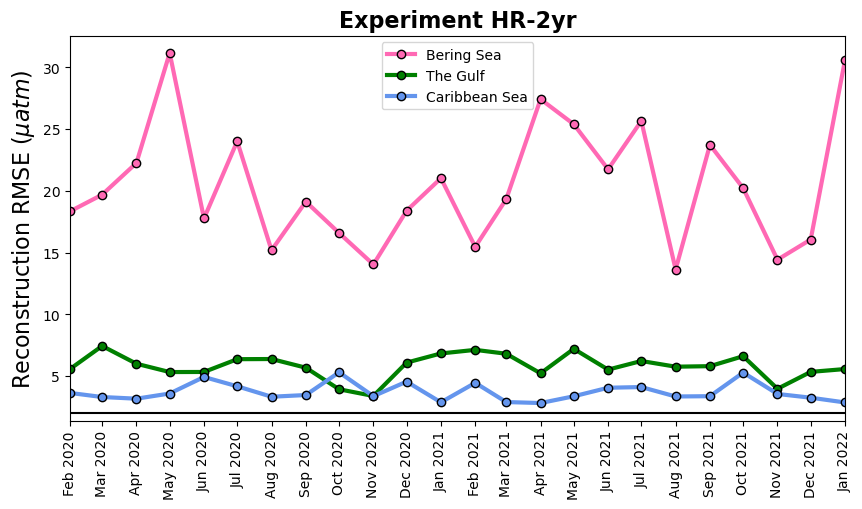

In [12]:
import matplotlib.dates as mdates
fig = plt.figure(figsize=(10,5))

plt.title('Experiment HR-2yr', fontsize=16, fontweight = 'bold')

plt.plot(rmse_bering_for_timeseries_global_2020_2022.time,rmse_bering_for_timeseries_global_2020_2022.mean(['longitude', 'latitude']),linewidth=3.0,label='Bering Sea', linestyle='solid',c='hotpink', marker='o',markersize=6, markeredgecolor='black', markeredgewidth=1) 
plt.plot(rmse_gulf_for_timeseries_global_2020_2022.time,rmse_gulf_for_timeseries_global_2020_2022.mean(['longitude', 'latitude']),linewidth=3.0,c='green',label='The Gulf', linestyle='solid', marker='o',markersize=6, markeredgecolor='black', markeredgewidth=1) 
plt.plot(rmse_caribbean_for_timeseries_global_2020_2022.time,rmse_caribbean_for_timeseries_global_2020_2022.mean(['longitude', 'latitude']),linewidth=3.0,c='cornflowerblue',label='Caribbean Sea', linestyle='solid', marker='o',markersize=6, markeredgecolor='black', markeredgewidth=1)#,alpha =0.5) 

plt.axhline(2,zorder=-10,c='black')
plt.ylabel('Reconstruction RMSE ($\mu atm$)', fontsize=16)
plt.xlim(rmse_caribbean_for_timeseries_global_2000_2022.time[0],rmse_caribbean_for_timeseries_global_2000_2022.time[-1])

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  

plt.xticks(rotation=90);  
plt.legend();
#plt.savefig("/home/jovyan/timeseries_rmse_Exp1.jpg",dpi=300, bbox_inches="tight")

## Figure 4a

<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_61/2908997677.py:12: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Reconstruction bias ($\mu atm$)', fontsize=16)


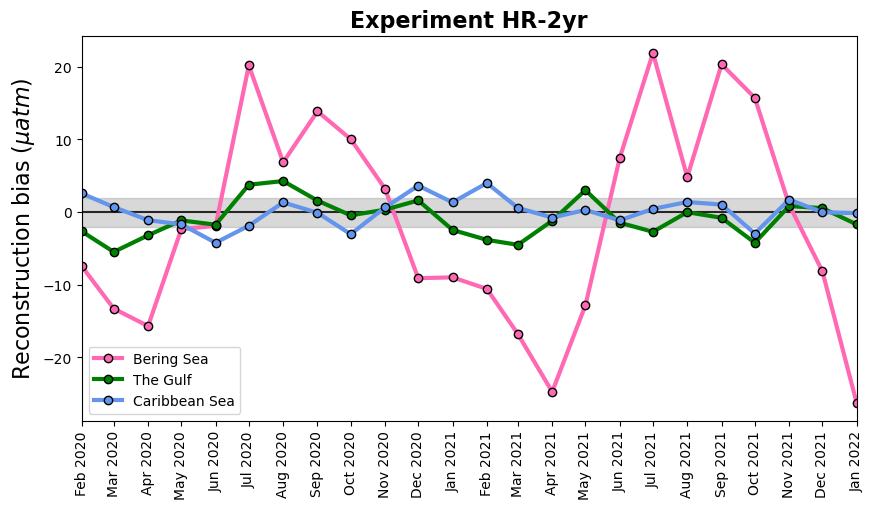

In [13]:
import matplotlib.dates as mdates
fig = plt.figure(figsize=(10,5))

plt.title('Experiment HR-2yr', fontsize=16, fontweight = 'bold')

plt.plot(bias_bering_for_timeseries_global_2020_2022.time,bias_bering_for_timeseries_global_2020_2022.mean(['longitude', 'latitude']),linewidth=3.0,c='hotpink',label='Bering Sea', linestyle='solid', marker='o',markersize=6, markeredgecolor='black', markeredgewidth=1)
plt.plot(bias_gulf_for_timeseries_global_2020_2022.time,bias_gulf_for_timeseries_global_2020_2022.mean(['longitude', 'latitude']),linewidth=3.0,c='green',label='The Gulf', linestyle='solid', marker='o',markersize=6, markeredgecolor='black', markeredgewidth=1)
plt.plot(bias_caribbean_for_timeseries_global_2020_2022.time,bias_caribbean_for_timeseries_global_2020_2022.mean(['longitude', 'latitude']),linewidth=3.0,c='cornflowerblue',label='Caribbean Sea', linestyle='solid', marker='o',markersize=6, markeredgecolor='black', markeredgewidth=1)

plt.fill_between(bias_caribbean_for_timeseries_global_2000_2022.time, -2, 2, color='grey', alpha=0.3)
plt.ylabel('Reconstruction bias ($\mu atm$)', fontsize=16)
plt.axhline(0,zorder=-10,c='black')
plt.xlim(bias_caribbean_for_timeseries_global_2000_2022.time[0],bias_caribbean_for_timeseries_global_2000_2022.time[-1])

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  
plt.xticks(rotation=90); 
plt.legend();
#plt.savefig("/home/jovyan/timeseries_bias_Exp1.jpg",dpi=300, bbox_inches="tight")

## Figure 5

<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_61/2592964961.py:12: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Reconstruction RMSE ($\mu atm$)', fontsize=16)


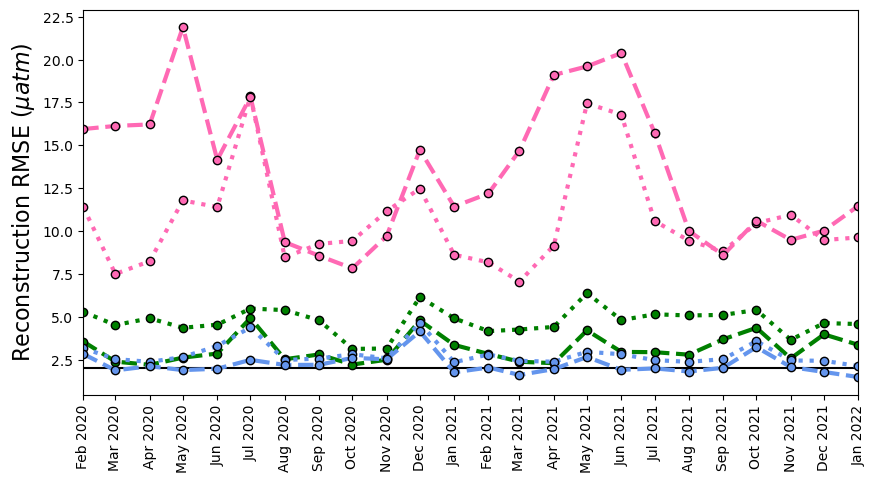

In [17]:
import matplotlib.dates as mdates
fig = plt.figure(figsize=(10,5))

plt.plot(rmse_bering_for_timeseries_global_2020_2022_float.time,rmse_bering_for_timeseries_global_2020_2022_float.mean(['longitude', 'latitude']),linewidth=3.0,label='Exp.2', linestyle='dotted',c='hotpink',  marker='o',markersize=6, markeredgecolor='black', markeredgewidth=1)
plt.plot(rmse_bering_for_timeseries_global_2000_2022.time,rmse_bering_for_timeseries_global_2000_2022.mean(['longitude', 'latitude']),linewidth=3.0,label='Exp.3', linestyle='dashed',c='hotpink', marker='o',markersize=6, markeredgecolor='black', markeredgewidth=1)
plt.plot(rmse_gulf_for_timeseries_global_2020_2022_float.time,rmse_gulf_for_timeseries_global_2020_2022_float.mean(['longitude', 'latitude']),linewidth=3.0,c='green',label='Exp.2', linestyle='dotted',  marker='o',markersize=6, markeredgecolor='black', markeredgewidth=1) 
plt.plot(rmse_gulf_for_timeseries_global_2000_2022.time,rmse_gulf_for_timeseries_global_2000_2022.mean(['longitude', 'latitude']),linewidth=3.0,c='green',label='Exp.3', linestyle='dashed', marker='o',markersize=6, markeredgecolor='black', markeredgewidth=1)
plt.plot(rmse_caribbean_for_timeseries_global_2020_2022_float.time,rmse_caribbean_for_timeseries_global_2020_2022_float.mean(['longitude', 'latitude']),linewidth=3.0,c='cornflowerblue',label='Exp.2', linestyle='dotted',  marker='o',markersize=6, markeredgecolor='black', markeredgewidth=1)
plt.plot(rmse_caribbean_for_timeseries_global_2000_2022.time,rmse_caribbean_for_timeseries_global_2000_2022.mean(['longitude', 'latitude']),linewidth=3.0,c='cornflowerblue',label='Exp.3', linestyle='dashed', marker='o',markersize=6, markeredgecolor='black', markeredgewidth=1)

plt.axhline(2,zorder=-10,c='black')
plt.ylabel('Reconstruction RMSE ($\mu atm$)', fontsize=16)
plt.xlim(rmse_caribbean_for_timeseries_global_2000_2022.time[0],rmse_caribbean_for_timeseries_global_2000_2022.time[-1])

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  

plt.xticks(rotation=90);  
#plt.savefig("/home/jovyan/timeseries_rmse_Exp2-3.jpg",dpi=300, bbox_inches="tight")

## Figure S2

<>:28: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:68: SyntaxWarning: invalid escape sequence '\m'
<>:28: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:68: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_61/3975151160.py:28: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Bias ($\mu$atm)', fontsize=14)
/tmp/ipykernel_61/3975151160.py:48: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Bias ($\mu$atm)', fontsize=14)
/tmp/ipykernel_61/3975151160.py:68: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Bias ($\mu$atm)', fontsize=14)


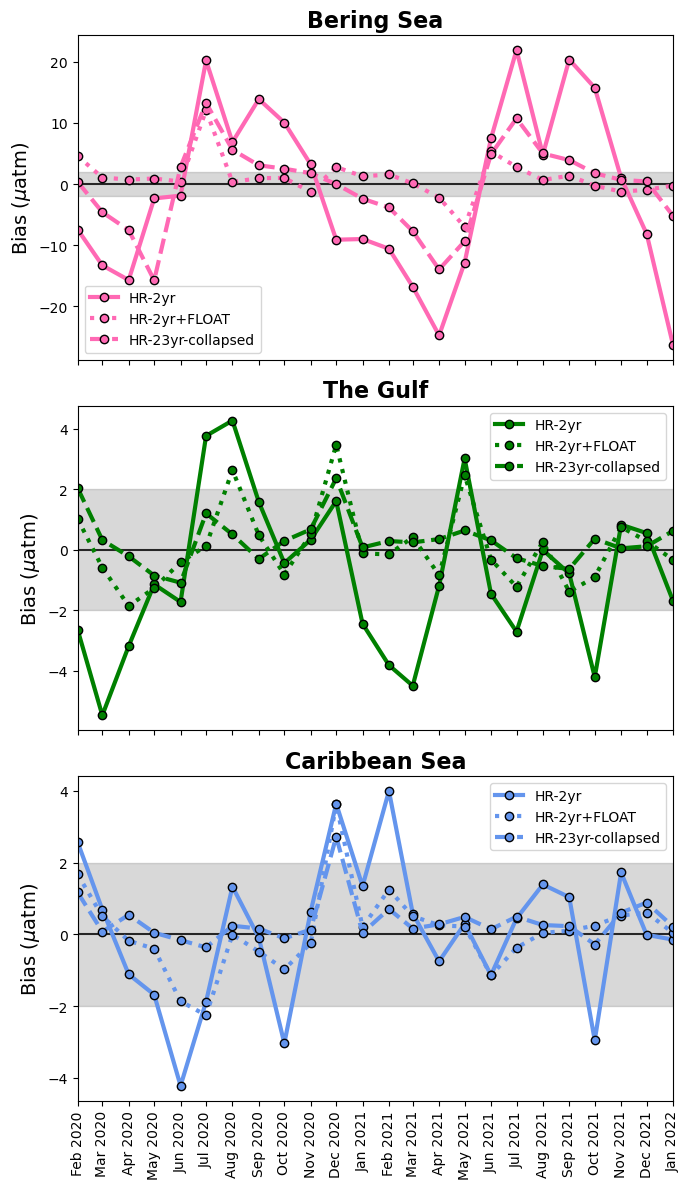

In [18]:
import matplotlib.dates as mdates
fig, axes = plt.subplots(3, 1, figsize=(7, 12), sharex=True)

start_time = np.datetime64('2020-02')
end_time = bias_caribbean_for_timeseries_global_2000_2022.time[-1].values  # exact endpoint

for ax in axes:
    ax.set_xlim(start_time, end_time)

# --- Panel 1: Bering Sea ---
ax = axes[0]
ax.set_title('Bering Sea', fontsize=16, fontweight = 'bold')
ax.plot(bias_bering_for_timeseries_global_2020_2022.time,
        bias_bering_for_timeseries_global_2020_2022.mean(['longitude', 'latitude']),
        linewidth=3.0, c='hotpink', label='HR-2yr', linestyle='solid',
        marker='o', markersize=6, markeredgecolor='black', markeredgewidth=1)
ax.plot(bias_bering_for_timeseries_global_2020_2022_float.time,
        bias_bering_for_timeseries_global_2020_2022_float.mean(['longitude', 'latitude']),
        linewidth=3.0, c='hotpink', label='HR-2yr+FLOAT', linestyle='dotted',
        marker='o', markersize=6, markeredgecolor='black', markeredgewidth=1)
ax.plot(bias_bering_for_timeseries_global_2000_2022.time,
        bias_bering_for_timeseries_global_2000_2022.mean(['longitude', 'latitude']),
        linewidth=3.0, c='hotpink', label='HR-23yr-collapsed', linestyle='dashed',
        marker='o', markersize=6, markeredgecolor='black', markeredgewidth=1)
ax.axhline(0, zorder=-10, c='black')
ax.fill_between(bias_bering_for_timeseries_global_2000_2022.time, -2, 2, color='grey', alpha=0.3)
ax.set_ylabel('Bias ($\mu$atm)', fontsize=14)
ax.legend(loc='lower left')

# --- Panel 2: Gulf ---
ax = axes[1]
ax.set_title('The Gulf', fontsize=16, fontweight = 'bold')
ax.plot(bias_gulf_for_timeseries_global_2020_2022.time,
        bias_gulf_for_timeseries_global_2020_2022.mean(['longitude', 'latitude']),
        linewidth=3.0, c='green', label='HR-2yr', linestyle='solid',
        marker='o', markersize=6, markeredgecolor='black', markeredgewidth=1)
ax.plot(bias_gulf_for_timeseries_global_2020_2022_float.time,
        bias_gulf_for_timeseries_global_2020_2022_float.mean(['longitude', 'latitude']),
        linewidth=3.0, c='green', label='HR-2yr+FLOAT', linestyle='dotted',
        marker='o', markersize=6, markeredgecolor='black', markeredgewidth=1)
ax.plot(bias_gulf_for_timeseries_global_2000_2022.time,
        bias_gulf_for_timeseries_global_2000_2022.mean(['longitude', 'latitude']),
        linewidth=3.0, c='green', label='HR-23yr-collapsed', linestyle='dashed',
        marker='o', markersize=6, markeredgecolor='black', markeredgewidth=1)
ax.axhline(0, zorder=-10, c='black')
ax.fill_between(bias_gulf_for_timeseries_global_2000_2022.time, -2, 2, color='grey', alpha=0.3)
ax.set_ylabel('Bias ($\mu$atm)', fontsize=14)
ax.legend(loc='upper right')

# --- Panel 3: Caribbean Sea ---
ax = axes[2]
ax.set_title('Caribbean Sea', fontsize=16, fontweight = 'bold')
ax.plot(bias_caribbean_for_timeseries_global_2020_2022.time,
        bias_caribbean_for_timeseries_global_2020_2022.mean(['longitude', 'latitude']),
        linewidth=3.0, c='cornflowerblue', label='HR-2yr', linestyle='solid',
        marker='o', markersize=6, markeredgecolor='black', markeredgewidth=1)
ax.plot(bias_caribbean_for_timeseries_global_2020_2022_float.time,
        bias_caribbean_for_timeseries_global_2020_2022_float.mean(['longitude', 'latitude']),
        linewidth=3.0, c='cornflowerblue', label='HR-2yr+FLOAT', linestyle='dotted',
        marker='o', markersize=6, markeredgecolor='black', markeredgewidth=1)
ax.plot(bias_caribbean_for_timeseries_global_2000_2022.time,
        bias_caribbean_for_timeseries_global_2000_2022.mean(['longitude', 'latitude']),
        linewidth=3.0, c='cornflowerblue', label='HR-23yr-collapsed', linestyle='dashed',
        marker='o', markersize=6, markeredgecolor='black', markeredgewidth=1)
ax.axhline(0, zorder=-10, c='black')
ax.fill_between(bias_caribbean_for_timeseries_global_2000_2022.time, -2, 2, color='grey', alpha=0.3)
ax.set_ylabel('Bias ($\mu$atm)', fontsize=14)
ax.legend(loc='upper right')

axes[2].xaxis.set_major_locator(mdates.MonthLocator())
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(axes[2].get_xticklabels(), rotation=90)

plt.tight_layout()
#plt.savefig("/home/jovyan/timeseries_bias_comparison.jpg", dpi=300, bbox_inches="tight")